<a href="https://colab.research.google.com/github/Sunjii/MusicVAE/blob/main/MusicVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사전 지식 탐색 및 정리

## VAE
- VAE는 latent representation에 효과적인 모델로 입증되었음
- AE와 형태면에서 비슷함. Bottleneck 구조를 통해 벡터를 압축하여 latent code를 생성. 
  - latent space를 통해 입력 데이터간의 유사성과 차이를 통해 학습
  - VAE는 AE와는 달리 Generative한 모델임.
  - 생성에 강점을 보이는 이유는 latent space가 연속되게 생성되기 때문. 반면 AE는 이산적인 분포를 가지기 때문에 데이터 재구성 단계에서 저품질의 데이터가 생기는 원인이 됨.
  - VAE는 KL-divergence를 loss 함수로 사용함
- KL-divergence를 통해서 VAE의 latent space 분포가 `표준 정규 분포`에 가깝도록 학습하게 됨

>참고링크: https://ratsgo.github.io/generative%20model/2017/12/19/vi/


---


## VAE 한계점

- sequential data에 한계점이 존재함.
- recurrent VAE 모델들은 long-term sequence에 약함
- 논문에서는 이러한 한계점을 극복하기 위해 `hierachical decoder`를 제안함
  - 첫번째 output embedding이 input의 sub-sequence로 쓰임
  - 각 embedding들은 독립적으로 sub-sequence들을 생성함
- 이러한 구조는 모델이 latent code를 utilize하고 `posterior collapse` 문제를 회피하는데 도움이 됨

  - posterior collapse: 시퀀스 모델을 VAE형태로 표현하면 global latent z를 이용하여 다양한 속성의 시퀀스를 생성할 수 있다. 하지만 이 때 decoder가 encoder의 condition을 무시하고 시퀀스를 생성하는 현상을 말함.

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fqd1lx%2FbtqXMfe0scF%2FYRdkqrZhcInlZ2yPRchOzK%2Fimg.png)

  - collapse 발생하는 이유
    - decoder가 latent z 없이 과거 데이터만으로 충분히 생성 가능한 경우
    - 다양한 latent z가 존재할 수 있음
    - VAE가 local information을 선호하는 경향이 있음
    - 학습 초기 encoder가 z를 잘 표현하지 못 해서 등등..
    - 참고링크: https://stopspoon.tistory.com/63

# Model
- RNN은 recurrent한 모델이기 때문에 latent code를 무시할 수 있음
- 전체 시퀀스를 단일 latent vector로 압축하게 되는데 따라서 long-term 시퀀스인 경우 정보의 손실일 일어날 수 있음
- 이 같은 문제를 해결하기 위해 `hierarchical RNN`을 디코더에 적용

![](https://i.imgur.com/y397wfb.png)

## Bidirectional Encoder
- 2 layer 양방향 LSTM 사용
- input 시퀀스 x로 첫번째 state vector $ \overrightarrow{h_{T}} $ 와 $ \overleftarrow{h_{T}} $ 를 두번째 bi-direction LSTM layer에서 얻는다.
- 이는 concat되어 $h_{T}$를 얻고 2개의 fully connectd layer로 들어간다.

$$ \mu = W_{h\mu}h_{T} + b_{\mu} $$

$$ σ = log(exp(W_{hσ} + b_{σ}) + 1) $$

$W_{hμ}, W_{hσ}$는 가중치 행렬이고, $b_μ, b_σ$는 bias 벡터이다. 논문에서는 2048개의 layer와 512의 latent 차원을 사용한다. 일반적인 VAE처럼 뮤와 시그마를 통해서 latent 분포를 표현할 수 있다. 양방향 recurrent encoder는 이상적으로 input 시퀀스의 long-term context를 잘 표현할 수 있다고 함.

## Hierarchical Decoder
- 단층 RNN을 사용한 경우 -> 매우 떨어지는 샘플링 및 재구성 성능을 보임
  - 출력 시퀀스가 생성되면서 latent state의 영향력이 점차 소실되기 때문 (vanishing)
- 이러한 문제를 해결하기 위해 계층적 RNN 구조를 디코더에 적용함
- input 시퀀스 x를 중복되지 않는 U개의 `sub sequence` $y_u$로 나누게 되면 다음처럼 표현 할 수 있음. 여기서 $i_u$는 endpoint임

$$ y_u = \{ x_{i_u}, x_{i_u+1}, x_{i_u+2}, ..., x_{i_u+1} -1 \} $$

$$ →X = \{ y_1, y_2, ..., y_U \} $$

- 위 식에서 $i_{U+1} = T$로 정의함. 이후 latent vector z는 fully-connetced layer를 통과하며 tanh 활성 함수를 거쳐 conductor RNN의 초기 state를 생성함.

- 논문에서는 Conductor를 위해서 2개층의 양방향 LSTM (hidden state size 1024, 512 output dimension)을 사용함.

### Conductor

- conductor가 임베딩 벡터 c를 생성하면 각 벡터는 독립적으로 fully-connected layer를 지나면서 tanh 활성함수를 통해 RNN decoder의 최종 바닥층의 초기 state를 생성함.
- RNN 디코더는 softmax 출력층을 거치면서 auto-regressive하게 시퀀스 분포를 생성함. 여기서 디코더는 서브시퀀스 $y_{u}$에 해당하는 분포를 생성함.
- 디코더의 바닥층에서는 매 step마다 conductor의 임베딩 $c_u$와 이전 step의 출력 토큰을 결합하여 input으로 사용함.
  - 이러한 계층적 구조때문에 각 서브시퀀스 $y_u$는 연결된 conductor에서 생성된 $c_u$를 통해서만 영향을 받음
- 논문에서는 2 layer LSTM과 각 layer마다 1024 units의 decoder RNN을 사용함.

### 결과

- 논문에서는 실험을 통해 decoder의 scope를 제한하는 것이 latent code를 사용하는 long-term 구조 모델에 중요하다는 사실을 발견함
- 각 서브시퀀스의 끝에서 decoder의 state가 다시 conductor로 들어가는 `auto regressive conductor`에서는 성능이 좋지 않았음.





# Implementation

## Data 

MIDI 데이터를 학습에 사용하기 위해서 벡터로 변환하는 전처리 과정이 필요하다.

[magenta](https://github.com/magenta/magenta/tree/main/magenta/models/music_vae) 를 이용하여 .mid, .midi 파일을 tfrecord 포멧으로 변환시킬 수 있다. 이후 학습에 사용하면 된다!

* tfrecord: 바이너리 데이터 포멧으로 serial 데이터를 읽는데 특화되어 있다. [참고링크](https://bcho.tistory.com/1190)

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive/')

# data dir
DATA_DIR = '/content/drive/MyDrive/musicVAE/data'
OUT_DIR = '/content/drive/MyDrive/musicVAE/data_out'

Mounted at /content/drive/


## 데이터 확인

간단하게 tfds에 있는 groove 데이터를 가져와서 사용하겠습니다. 4마디 드럽 샘플을 뽑아내기 위해 4마디 데이터셋인 groove/4bar-midionly를 가져옵니다.

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import keras

groove = tfds.builder(
    name="groove/4bar-midionly", # 4마디 드럼 데이터셋을 불러옵니다.
    )
print(groove.info)
print(groove.info.features['midi'])
print(groove.info.features['drummer'].names)
print(groove.info.features['style']['primary'].names)


tfds.core.DatasetInfo(
    name='groove',
    version=2.0.1,
    description='The Groove MIDI Dataset (GMD) is composed of 13.6 hours of aligned MIDI and
(synthesized) audio of human-performed, tempo-aligned expressive drumming
captured on a Roland TD-11 V-Drum electronic drum kit.',
    homepage='https://g.co/magenta/groove-dataset',
    features=FeaturesDict({
        'bpm': tf.int32,
        'drummer': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
        'id': tf.string,
        'midi': tf.string,
        'style': FeaturesDict({
            'primary': ClassLabel(shape=(), dtype=tf.int64, num_classes=18),
            'secondary': tf.string,
        }),
        'time_signature': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
        'type': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=21415,
    splits={
        'test': 2033,
        'train': 17261,
        'validation': 2121,
    },
    supervised_keys=None,
    citation="""@inpro

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
# Load the full GMD with MIDI only (no audio) as a tf.data.Dataset
train_dataset, val_dataset, test_dataset = tfds.load(
    name="groove/4bar-midionly", # 4마디 드럼 데이터셋을 불러옵니다.
    split=(tfds.Split.TRAIN, tfds.Split.VALIDATION, tfds.Split.TEST),
    try_gcs=True,
    )


# Build your input pipeline
train_dataset = train_dataset.shuffle(1024).batch(32).prefetch(
    tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.shuffle(1024).batch(32).prefetch(
    tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.shuffle(1024).batch(32).prefetch(
    tf.data.experimental.AUTOTUNE)

print(len(train_dataset), len(val_dataset), len(test_dataset))
for features in train_dataset.take(1):
  # Access the features you are interested in
  midi = features["midi"]
  print('=============')
  print(midi.shape)
  print(midi)


## VAE
![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fqd1lx%2FbtqXMfe0scF%2FYRdkqrZhcInlZ2yPRchOzK%2Fimg.png)

- 인코더

양방향 LSTM encoder 사용

- 디코더

단방향 LSTM decoder 사용

## Hierarchical Decoder

- Conductor

- 논문에서 진행한 방식에 따라 모델 구축 및 변수 설정을 하겠습니다.
- 변수 설정
  - 2-bar data -> T = 32
  - 16-bar data -> T = 256
  - 4-bar data -> T = 64가 됩니다.
  - U = 16, 전체 입력 X는 16개의 서브시퀀스로 나뉘게 됩니다.
  - Adam 을 사용했으며, lr_rate는 1e-3 ~ 1e-5 이며 exponential decay rate는 0.9999를 사용함
  - batch_size는 512
  - loss는 cross-entropy 사용
  - 2-bar model and teacher forcing for 16-bar model

- 기타 파라미터
  - max_seq_len = 64 # 4마디 길이
  - z_size = 512 # latent vector size
  - slice_bars = 4 # 4마디

In [ ]:
import numpy as np


#def kl_divergence(p, q):
  #return p*tf.math.log(p/q) + (1-p)*tf.math.log((1-p) / (1-q))

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))


def sampling(inputs):
  """
  return
    z: latent vector
  """
  z_mean, z_log_var = inputs
  eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
  z = z_mean + tf.exp(z_log_var / 2) * eps
  
  return z



In [ ]:
hidden_dim = 512
latent_dim = 2
num_feat = 1 ## data feature?
batch_size = 32

In [ ]:
# encoder
inputs = keras.layers.Input(shape=(num_feat, ), name='midi')
x = keras.layers.Dense(hidden_dim, activation='tanh')(inputs)
z_mean = keras.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = keras.layers.Dense(latent_dim, name='z_log_var')(x)

In [ ]:
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 midi (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 dense_32 (Dense)               (None, 512)          1024        ['midi[0][0]']                   
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['dense_32[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['dense_32[0][0]']               
                                                                                            

In [ ]:
# decoder 

latent_inputs = keras.layers.Input(shape=(latent_dim, ), name='z_sampling')
x = keras.layers.Dense(hidden_dim, activation='tanh')(latent_inputs)
outputs = keras.layers.Dense(num_feat, activation='tanh')(x)

decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()



Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_33 (Dense)            (None, 512)               1536      
                                                                 
 dense_34 (Dense)            (None, 1)                 513       
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
outputs = decoder(encoder(inputs)[2])

vae = keras.Model(inputs, outputs, name='vae')

loss = tf.losses.binary_crossentropy(inputs, outputs)
kl_loss = tf.losses.kl_divergence(inputs, outputs)
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 midi (InputLayer)           [(None, 1)]               0         
                                                                 
 encoder (Functional)        [(None, 2),               3076      
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 1)                 2049      
                                                                 
Total params: 5,125
Trainable params: 5,125
Non-trainable params: 0
_________________________________________________________________


In [ ]:

vae.add_loss(kl_loss)
vae.compile(optimizer='adam')

TypeError: ignored

In [ ]:
vae.fit(train_dataset, epochs=1, batch_size=batch_size, validation_data=val_dataset)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['bpm', 'drummer', 'id', 'style', 'time_signature', 'type'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


StagingError: ignored

### PyTorch

![](https://gaussian37.github.io/assets/img/dl/concept/vae/0.png)
![](https://i.imgur.com/y397wfb.png)

파이토치로 구현

- Encoder
  - mu:
  - sigma:
  - z:
- Decoder
  - x'

- Condutor
  - 


### VAE with MNIST data

In [ ]:
import os
from time import time
import datetime
import torch
import torchvision
from torch import nn
import torch.optim as optim
from torch.nn import functional as F

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

current_time = datetime.datetime.now() + datetime.timedelta(hours=9) # 시차
current_time = current_time.strftime('%Y-%m-%d-%H:%M')
saved_loc = os.path.join('/drive/MyDrive/VAE_Result', current_time)
os.makedirs(saved_loc)

writer = SummaryWriter(saved_loc)
EPOCHS = 50
BATCH_SIZE = 200

VAE의 가장 핵심은 인코더-디코더 구조와 mu, sigma이다.

먼저 인코더는 데이터를 받아와서 mu와 sigma를 출력해야 한다. 인코더는 데이터를 입력받아 hidden_size 만큼 출력하고, 이를 받아서 다시 latent_size 만큼의 mu와 sigma를 출력한다

이 작업은 encode 함수를 통해 이루어진다.

그 다음에는 reparameterization 과정이 필요하다. 만약 인코더의 결과물을 바로 디코더로 넘긴다면 어떻게 될까? 당연히 한 가지 값만 가지므로 그에대한 디코더 값 역시 한 값만 나오게 된다. 즉, 어떤 입력에 대해서 무조건 똑같은 output이 나오게 된다.

하지만 VAE는 Generative 모델이다. 이는 곧 data의 분포를 가지고서 기존에 없는 새로운 data를 생성하고자 하는 것이다. 따라서 data의 분포를 샘플링 하되 reparmeterization을 적용한다.

마지막으로 디코더 과정이다. self.decode(z)의 결과는 입력 데이터의 사이즈와 동일한 차원을 가지면서 sigmoid를 통과하므로 0~1 사이의 값을 갖게 된다. 이는 곧 input으로 투입한 데이터를 VAE를 거쳐 복원한 것이라고 볼 수 있다...


출처: https://github.com/PeterKim1/paper_code_review

In [ ]:
import torchvision.transforms as transforms
# Transformer code
transformer = transforms.Compose([
            transforms.ToTensor()
])

# Loading trainset, testset and trainloader, testloader
trainset = torchvision.datasets.MNIST(root = '/content/drive/MyDrive/MNIST', train = True,
                                        download = True, transform = transformer)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)


testset = torchvision.datasets.MNIST(root = '/content/drive/MyDrive/MNIST', train = False,
                                        download = True, transform = transformer)

testloader = torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/MNIST/MNIST/raw



<class 'torch.Tensor'>
torch.Size([3, 32, 242])


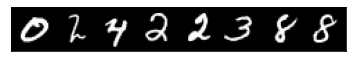

In [ ]:
# sample check
sample, label = next(iter(trainloader))

# show grid image
def imshow_grid(img):
    img = torchvision.utils.make_grid(img)
    print(type(img))
    print(img.shape)
    plt.imshow(img.permute(1, 2, 0))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()


imshow_grid(sample[0:8])

### Model 부분

In [ ]:
# VAE Model

class VAE_Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, latent_size, output_size, num_layers=1, bidirectional=True):
    """
    input_size: dim of input
    hidden_size: LSTM hidden size
    latent_size: dim of latent
    num_layers: number of LSTM layers
    bidirectional : 
    """
    super(VAE_Encoder, self).__init__()

    if bidirectional == True:
      num_directions = 2
    else:
      num_directions = 1
    
    # encoder

    self.hidden_size = hidden_size
    self.num_hidden = num_directions * num_layers
    self.output_size = self.num_hidden * hidden_size

    self.lstm = nn.LSTM(batch_first=True, # ?
                        input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers=num_layers,
                        bidirectional=bidirectional)
    
    self.mu = nn.Linear(self.output_size, latent_size)
    self.std = nn.Linear(self.output_size, latent_size)
    self.norm = nn.LayerNorm(latent_size, elementwise_affine=False) # ?


  def encode(self, x):
    x, (h, c) = self.lstm(x)
    h = h.transpose(0, 1).reshape(-1, self.output_size)

    mu = self.norm(self.mu(h))
    std = nn.Softplus()(self.std(h)) # ?

    # reparam
    z = self.reparam(mu, std)
    
    return z, mu, std


  def reparam(self, mu, std):
    eps = torch.randn_like(std)
    # randn_like: input을 평균이 0, 분산이 1인 정규분포의 난수로 채워진 동일 크기 텐서 반환

    return mu + (eps * std)



  def forward(self, x):
    z, mu, std = self.encode(x)
    return z, mu, std


def vae_loss(recon_x, x, mu, std, beta=0):
  logvar = std.pow(2).log()
  BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return BCE + (beta * KLD)

def accuracy(y_true, y_pred):
  y_ture = torch.argmax(y_true, axis=2)
  total_num = y_true.shape[0] * y_true.shape[1]

  return torch.sum(y_ture == y_pred) / total_num


In [ ]:
class VAE_Decoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=2):
    super(VAE_Decoder, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_hidden = 1 * num_layers

    self.logits = nn.Linear(hidden_size, output_size)
    self.decoder = nn.LSTM(batch_first=True,
                           input_size=input_size+output_size,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           bidirectional=False)
  
  def forward(self, x, h, c, temp=1):
    """
    x: input seq
    h: LSTM state (num_hidden, batch, hidden_size)
    c: LSTM cell (num_hidden, batch, hidden_size)
    temp: temperature of softmax

    Returns
    -------
    out: predicted label (bathc, 1, output_size)
    prob: predicted prob( batch, 1, output_size)
    h : next LSTM state
    c : next LSTM cell
    """

    x, (h, c) = self.decoder(x, (h, c))
    logits = self.logits(x) / temp
    prob = nn.Softmax(dim=2)(logits)
    out = torch.argmax(prob, 2)

    return out, prob, h, c

    

In [ ]:
class Conductor(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers=2, bidirectional=False, bar=4):
    """
    input_size: input dim
    hidden_size: dim of LSTM hidden size
    output_size: dim of output seq
    num_layers: number of LSTM layers
    bar: number of units in bar
    """

    super(Conductor, self).__init__()
    self.bar = bar
    
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_hidden = 1 * num_layers

    self.norm = nn.BatchNorm1d(input_size)
    self.linear = nn.Linear(hidden_size, hidden_size)
    self.conductor = nn.LSTM(batch_first=True,
                             input_size=input_size,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             bidirectional=bidirectional)
    
  def init_hidden(self, batch_size, z): # ??
    h0 = z.repeat(self, num_hidden, 1, 1)
    c0 = z.repeat(self, num_hidden, 1, 1)
    return h0, c0

  def forward(self, z):
    """
    z: latent z (batch, input_size)

    Returns
    -------
    feat: conductor feat (batch, bar_seq, hidden_size)
    """

    batch_size = z.shape[0]

    z = self.norm(z) # ? paper와 다른 부분
    h, c = self.init_hidden(batch_size, z)
    z = z.unsqueeze(1) # ?

    # initialize
    feat = torch.zeors(batch_size, self.bar, self.hidden_size, device=device)

    # conductor
    z_input = z
    for i in range(self.bar):
      z_input, (h, c) = self.conductor(z_input, (h, c))
      feat[:, i, :] = z_input.squeeze()
      z_input = z
    
    feat = self.linear(feat)
    return feat



In [ ]:
class Hierarchical_Decoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=2, bidirectional=False):
    """
    """
    super(Hierarchical_Decoder, self).__init__()

    if bidirectional == True:
      num_directions = 2
    else:
      num_directions = 1
    
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_hidden = num_directions * num_layers

    self.logits = nn.Linear(hidden_size, output_size)
    self.decoder = nn.LSTM(batch_first=True,
                           input_size=input_size + output_size,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           bidirectional=bidirectional)
  
  def forward(self, x, h, c, z, temp=1):
    """
    x: input seq (batch, 1, feat)
    h: LSTM state (num_hidden, batch, hidden_size)
    c: LSTM cell (num_hidden, batch, hidden_size)
    z: latent feature
    temp: temperature of softmax

    RETURNs
    ----------
    out:
    prob:
    h:
    c:
    """

    x = torch.cat((x, z.unsqueeze(1)), 2) # ??

    x, (h, c) = self.decoder(x, (h, c))
    logits = self.logtis(x) / temp
    prob = nn.Softmax(dim=2)(logits)
    out = torch.argmax(prob, 2)

    return out, prob, h, c

In [ ]:
def inverse_sigmoid(epoch, k=20):
    return k / (k + np.exp(epoch/k))

def kl_annealing(epoch, start, end, rate=0.9):
    return end + (start - end)*(rate)**epoch

In [ ]:
def flat_train(loss_fn, train_loader, val_loader, model, optimizer, temp=1, epochs=100):
  history = {}
  history['train_loss'] = []
  history['train_acc'] = []
  history['val_loss'] = []
  history['val_acc'] = []

  encoder, decoder = model
  enc_optim, dec_optim = optimizer

  hidden_size = decoder.hidden_size
  num_hidden = decoder.num_hidden
  output_size = decoder.output_size

  enc_sch = optim.lr_scheduler.CosineAnnealingLR(enc_optim, epochs, eta_min=1e-6) #?
  dec_sch = optim.lr_scheduler.CosineAnnealingLR(dec_optim, epochs, eta_min=1e-6)

  for i in range(1, epochs+1):
    st = time()
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    encoder.train()
    decoder.train()

    for batch_idx, x_train in enumerate(train_loader):
      x_train = x_train.to(device)

      batch_size = x_train.shape[0]
      seq_len = x_train.shape[1]

      enc_optim.zero_grad()
      dec_optim.zero_grad()

      # encoder
      z, x_train_mu, x_train_std = encoder(x_train)

      h = z.repeat(num_hidden, 1, int(hidden_size/z.shape[1]))
      c = z.repeat(num_hidden, 1, int(hidden_size/z.shape[1]))

      x_train_inputs = torch.zeros((batch_size, 1, x_train.shape[2]), device=device)
      x_train_inputs = torch.cat((x_train_inputs, z.unsqueeze(1)), 2)
      x_train_label = torch.zeros(x_train.shape[:-1], device=device) # argmax
      x_train_prob = torch.zeros(x_train.shape, device=device) # prob

      # forward
      for j in range(seq_len):
        label, prob, h, c = decoder(x_train_inputs, h, c, temp=1)

        x_train_label[:, j] = label.squeeze()
        x_train_prob[:, j, :] = prob.squeeze()

        # scheduled sampling
        if np.random.binomial(1, inverse_sigmoid(i)): # ???
          # teacher forcing ?
          x_train_inputs = torch.cat((x_train[:, j, :], z), 1).unsqueeze(1)
        else:
          # sampling
          label = F.one_hot(label, num_classes=output_size)
          x_train_inputs = torch.cat((label, z.unsqueeze(1)), 2)
      
      # loss
      beta = kl_annealing(i, 0, 0.2)
      loss = loss_fn(x_train_prob, x_train, x_train_mu, x_train_std, beta)

      # backward
      loss.backward()
      enc_optim.step()
      dec_optim.step()

      train_loss += loss.item()
      train_acc += accuracy(x_train, x_train_label).item()

    enc_sch.step()
    dec_sch.step()

    train_loss = train_loss / (batch_idx + 1)
    train_acc = train_acc / (batch_idx + 1)

    history['train_loss'].append(train_loss)
    history['traina_acc'].append(train_acc)

    ### validation
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
      for batch_idx, x_val in enumerate(val_loader):
        x_val = x_val.to(device)

        batch_size = x_val.shape[0]
        seq_len = x_val.shape[1]

        # forward encoder
        z, x_val_mu, x_val_std = encoder(x_val)

        # initialize
        h = z.repeat(num_hidden, 1, int(hidden_size / z.shape[1]))
        c = z.repeat(num_hidden, 1, int(hidden_size / z.shape[1]))

        # full sampling
        x_val_inputs = torch.zeros((batch_size, 1, x_val.shape[2]), device=device)
        x_val_inputs = torch.cat((x_val_inputs, z.unsqueeze(1)), 2)
        x_val_label = torch.zeros(x_val.shape[:-1], device=device)
        x_val_prob = torch.zeros(x_val.shape, device=device)

        # forward
        for j in range(seq_len):
          label, prob, h, c = decoder(x_val_inputs, h, c, temp=1)

          x_val_label[:, j] = label.squeeze()
          x_val_prob[:, j, :] = prob.squeeze()

          label = F.one_hot(label, num_classes=output_size)
          x_val_inputs = torch.cat((label, z.unsqueeze(1)), 2)

        loss = loss_fn(x_val_prob, x_val, x_val_mu, x_val_std, beta)

        val_loss += loss.item()
        val_acc += accuracy(x_val, x_val_label).item()

    val_loss = val_loss / (batch_idx + 1)
    val_acc = val_acc / (batch_idx + 1)

    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print('Epoch %d (%0.2f sec) - train_loss: %0.3f, train_acc: %0.3f, val_loss: %0.3f, val_acc: %0.3f, lr: %0.6f' % \
             (i, time()-st, train_loss, train_acc, val_loss, val_acc, enc_sch.get_last_lr()[0]))
    
    return history



### Drum <-> Numpy

In [ ]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 4.4 MB/s 
     |████████████████████████████████| 51 kB 8.3 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=c75765a104fc7b964f5dcf98f04b3d3ea165eb18bfcabc45bb7484a0d843bfe8
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [ ]:
import pretty_midi

def drum_play(array, fs, comp=9):
    """Convert numpy object to pretty_midi 
     
    Parameters
    ----------
    array : numpy array (seq, feat)
    fs : sampling rate that you intended
    comp : the number of drum components
    Returns
    -------
    pm : pretty_midi object
    """
        
    fs_time = 1 / fs
    
    standard, encoded = get_comp()
    reverse_standard = {v: k for k, v in standard.items()}
    reverse_encoded = {v: k for k, v in encoded.items()}
    
    decimal_idx= np.where(array == 1)[1]
    binary_idx = list(map(lambda x: np.binary_repr(x, comp), decimal_idx))
    
    # initialize
    pm = pretty_midi.PrettyMIDI()
    inst = pretty_midi.Instrument(program=32, is_drum=True)
    pm.instruments.append(inst)
    
    for i, inst_in_click in enumerate(binary_idx):
        start_time = fs_time * i
        end_time = fs_time * (i + 1)
        
        # add instruments
        for j in range(0, len(inst_in_click)):
            if inst_in_click[j] == '1':
                pitch = reverse_standard[reverse_encoded[j]]
                inst.notes.append(pretty_midi.Note(80, pitch, start_time, end_time))
                
    return 

### MusicVAE flat

In [ ]:
path = '/content/drive/Mydrive/'

squeeze 함수
- 차원이 1인 차원을 제거한다. 따로 설정하지 않으면 1인 차원을 모두 제거함. 차원 설정 시 해당 차원만 제거함
- 주의점: batch가 1인 경우 batch 차원도 없애버릴 수 있으니, validation 단계에서 오류가 날 수 있음. 주의해서 사용

unsqueeze 함수
- squeeze와는 달리 1인 차원을 생성함. 어느 차원에 1인 차원을 생성할지 꼭 지정해야 함


In [ ]:
import torch
x1 = torch.rand(3, 1, 20, 128)
x1 = x1.squeeze()

x2 = torch.rand(1, 20, 1, 128)
x2 = x2.squeeze(dim=2)

print(x1.shape, x2.shape)

x = torch.rand(3, 20, 128)
x = x.unsqueeze(dim=1)
print(x.shape)

torch.Size([3, 20, 128]) torch.Size([1, 20, 128])
torch.Size([3, 1, 20, 128])


In [ ]:

def train(epoch, model, train_loader, optimizer):
  model.train()
  train_loss = 0
  for bat_idx, (data, _) in enumerate(train_loader): # 라벨이 필요가 없음 _
    data = data.to(device)
    optimizer.zero_grad()

    recon_batch, mu, logvar = model(data)

    BCE, KLD = loss_function(recon_batch, data, mu, logvar)
    loss = BCE + KLD

    writer.add_scalar("Train/Reconstruction Error", BCE.item(), bat_idx + epoch * (len(train_loader.dataset)/BATCH_SIZE) )
    writer.add_scalar("Train/KL-Divergence", KLD.item(), bat_idx + epoch * (len(train_loader.dataset)/BATCH_SIZE) )
    writer.add_scalar("Train/Total Loss" , loss.item(), bat_idx + epoch * (len(train_loader.dataset)/BATCH_SIZE) )


    loss.backward()
    train_loss += loss.item()
    optimizer.step()

    if bat_idx % 100 == 0:
      print('Train epo: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
          epoch, bat_idx * len(data), len(train_loader.dataset),
          100. * bat_idx / len(train_loader),
          loss.item() / len(data)
          ))
    
  print('===========> Epoch: {} Avg loss: {:.4f}'.format(
      epoch, train_loss / len(train_loader.dataset)
  ))

In [ ]:
input_size = 784
VAE_model = VAE(input_size, 512, 2).to(device)
optimizer = optim.Adam(VAE_model.parameters(), lr=1e-3)

In [ ]:
def test(epoch, model, test_loader):
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for bat_idx, (data, _) in enumerate(test_loader):
      data = data.to(device)

      recon_batch, mu, logvar = model(data)
      BCE, KLD = loss_function(recon_batch, data, mu, logvar)

      loss = BCE + KLD

      writer.add_scalar("Test/Reconstruction Error", BCE.item(), bat_idx + epoch * (len(test_loader.dataset)/BATCH_SIZE) )
      writer.add_scalar("Test/KL-Divergence", KLD.item(), bat_idx + epoch * (len(test_loader.dataset)/BATCH_SIZE) )
      writer.add_scalar("Test/Total Loss" , loss.item(), bat_idx + epoch * (len(test_loader.dataset)/BATCH_SIZE) )

      test_loss += loss.item()

      if bat_idx == 0:
        n = min(data.size(0), 8) # test_loader 데이터 8개와 이를 VAE를 거쳐 뽑은 reconstruction 결과 8개와 합친다 -> 16, 1, 28, 28
        comparison = torch.cat([data[:n], recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]]) # (16, 1, 28, 28)
        grid = torchvision.utils.make_grid(comparison.cpu()) # (3, 62, 242)
        writer.add_image('Test image - Above: Realdata, below: reconstruction data', grid, epoch) # tensorboard




In [ ]:
def latent_to_image(epoch, model):
  # latent를 이미지로 변환
  with torch.no_grad():
    sample = torch.randn(64, 2).to(device) # 랜덤 값 생성 (평균0, 분산1 가우시안 분포)
    recon_image = model.decode(sample).cpu() # decode를 통해 reconstruction 이미지 생성
    grid = torchvision.utils.make_grid(recon_image.view(64, 1, 28, 28))
    writer.add_image('Latent to Image', grid, epoch)

In [ ]:
# 학습 진행
for epoch in tqdm(range(0, EPOCHS)):
  train(epoch, VAE_model, trainloader, optimizer)
  test(epoch, VAE_model, testloader)
  print()
  latent_to_image(epoch, VAE_model)

writer.close()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir='/content/drive/MyDrive/VAE_Result'

## VAE with music midi

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, latent_dim):
    super(Encoder, self).__init__()
    self.hidden_size = hidden_size
    self.num_hidden = 2*2
    self.final_size = self.num_hidden * hidden_size

    self.lstm = nn.LSTM(batch_first=True,
                        input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers=2,
                        bidirectional=True)
    
    self.mu = nn.Linear(self.final_size, latent_dim)
    self.sigma = nn.Linear(self.final_size, latent_dim)
    self.z = nn.Linear(self.final_size, )
  
  def encode(self, x):
    x, (hidden, cells) = self.lstm(x)
    hidden = hidden.transpose(0, 1).reshape(-1, self.final_size)

    mu = 
    sigma = 

    return z, mu, sigma


SyntaxError: ignored

In [ ]:
class Conductor(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(Conductor, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_hidden = 2
    self.bar = 4

    self.lstm = nn.LSTM(batch_first=True,
                        input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers=1,)
    
    def forward(self, x):
      pass
      return a, b
    



In [ ]:
class Decoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(Decoder, self).__init__()

    self.input_size = input_size
    self.hidden_size=hidden_size
    self.output_size=output_size
    self.lstm = nn.LSTM(batch_first=True,
                        input_size=input_size+output_size,
                        hidden_size=hidden_size,
                        bidirectional=False)
    self.logits = nn.Linear(hidden_size, output_size)

    def decode(self, x, hidden, cells):
      x, (hidden, cells) = self.lstm(x, (hidden, cells))
      logits = self.logits(x)
      prob = nn.Softmax()(logits)
      output = torch.argmax(prob)
      
      return output, prob, hidden, cells

# magenta 활용

magenta 라이브러리를 이용하여 다른 데이터셋으로 musicVAE를 학습할 수 있다.

[참고링크](https://github.com/magenta/magenta/tree/main/magenta/models/music_vae)

In [ ]:
!pip install -q magenta

In [ ]:
!curl https://raw.githubusercontent.com/tensorflow/magenta/main/magenta/tools/magenta-install.sh > /tmp/magenta-install.sh
!bash /tmp/magenta-install.sh

MyDrive/musicVAE/data 폴더에 groove MIDI [데이터셋](https://magenta.tensorflow.org/datasets/groove#midi-data)을 압축 해제하고 사용합니다.

In [ ]:
!convert_dir_to_note_sequences --input_dir='/content/drive/MyDrive/musicVAE/data' --output_file=notesequences.tfrecord --recursive

In [ ]:
!music_vae_train --config=groovae_4bar --run_dir=music_vae/ --num_steps=2000 --mode=train --examples_path=notesequences.tfrecord \
--hparams=max_seq_len=64, z_size=512, batch_size=32, learning_rate=0.0005

In [ ]:
!music_vae_generate --config=groovae_4bar --checkpoint_file=music_vae/train --mode=sample --num_output=5 --output_dir=music_vae/generated